In [1]:
# Suppose you ask a complex question to thousands of random people, then aggregate the answers. In many cases, the aggregate answer is better than an expert's answer.
# Similarly, if you aggregate the predictions of a group of predictors, you will often get better predictions than with the best individual predictor.

# A group of predictors is called an Ensemble, and this technique is called Ensemble Learning, and an Ensemble Learning Algorithm is called an Ensemble Method.

# For example, you can train a group of Decision Tree Classifiers, each on a different random subset of the training set.
# To make predictions you obtain the predictions of all the individual trees, then predict the class that gets the most votes.
# This is called a Random Forest, and is one of the most powerful ML algorithms available today.

# In this chapter, we will discuss the most popular Ensemble methods, including:
    # Bagging
    # Boosting
    # Stacking
    # Random Forests
    # A few others...

In [2]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# To make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ensembles"

def image_path(fig_id):
    return os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id)

def save_fig(fig_id, tight_layout=True):
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(image_path(fig_id) + ".png", format='png', dpi=300)

# Voting Classifiers

In [3]:
# Suppose you've trained a few classifiers, each one achieving around 80% accuracy.
# You may have a Logistic Regression classifier, an SVM classifier, a Random Forest Classifier, a K-Nearest Neighbors classifier and a few more.
# A very simple way to create an even better classifier is to aggregate the predictions of each classifier and predict the class that gets the most votes.
# Types of Voting Classifiers:
    # Hard Voting Classifier: majority vote
# Even if each individual classifier is a weak learner, the ensemble creates a strong learner provided there is a sufficient diversity of weak learners.


In [4]:
# Why do ensemble classifiers work? Consider the Law of Large Numbers. Basically it states that as the number of instances and classifiers increases, you get closer and closer to the predicted mathematical probability.
# Let's consider the example of a coin toss. Note how the plot changes as the number of coin tosses increases. The actual probability moves closer and closer to the mathematical prob.

heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) /np.arange(1, 10001).reshape(-1, 1)

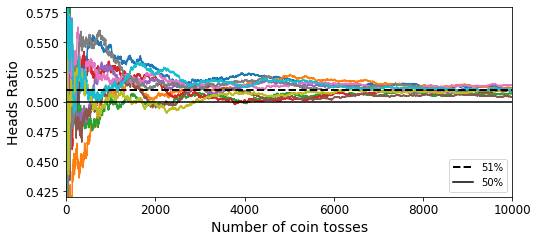

In [5]:
plt.figure(figsize=(8, 3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads Ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
plt.savefig("law_of_large_numbers_plot")
plt.show()

In [6]:
# The increase in accuracy from the Ensemble Method is more likely to occur if all classifiers are perfectly independent, making uncorrelated errors.... Which is often not the case because they are trained on the same data.
# They are likely to make the same type of errors, so there will be many majority votes for the wrong class, reducing the ensemble's accuracy.

# Ensembles work best when predictors are as independent from each other as possible.
    # One way to increase independence is to train them using very different algorithms. This will increase the chances that they will make very different types of errors, improving the ensemble's accuracy.
    

In [7]:
# The following code creates and trains a voting classifier in Scikit-Learn, composed of three diverse classifiers using the moons dataser:

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise= 0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver="liblinear", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
svm_clf = SVC(gamma="auto", random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')

In [9]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='warn',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=42,
                                                 solver='liblinear', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     class_weight=None,
                                                     criterion='gin...
                                        

In [10]:
# Now let's look at each classifier's accuracy on the test set:

from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))
    
# As you can see in the output below, the voting classifier slightly outperforms all individual classifiers.
# With Soft voting you can get an even higher accuracy of 91% at the expense of greater computing time.

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.896


# Bagging and Pasting

In [11]:
# One way to get a diverse set of classifiers is to use very different training algorithms as we just discussed.
# However, another way is to use the same algorithm for every predictor, but to train them on different random subsets of the training set.
# When sampling is performed with replacement this method is called bagging.
# When sampling is performed without replacement, this method is called pasting.

# Once all the predictors are trained, the ensemble can make a prediction using the most frequent prediction or the average for regression.
# Predictors can be trained in parallel via different CPU cores or even servers.
# Also predictions can be made in parallel. The ability for bagging and pasting to be scaled to hardware contributes to its great popularity.

In [12]:
# The following code trains an ensemble of 500 Decision Tree classifiers each trained on 100 training instances randomly sampled from a training set with replacement.
# This is an example of bagging but if you want to use pasting instead, set bootstrap=False.
# The n_jobs parameter tells Scikit-Learn the number of CPU cores to use for training and predictions (-1 tells to use all available cores)

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred =bag_clf.predict(X_test)

# The BaggingClassifier automatically performs soft voting if the base classifier can estimate class probabilities, which is the case with Decision Trees Classifiers.

In [13]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.904


In [14]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


In [15]:
# Following code outputs a plot that compares classification using only a Decision Tree and using a Decision Tree with Bagging.

from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)



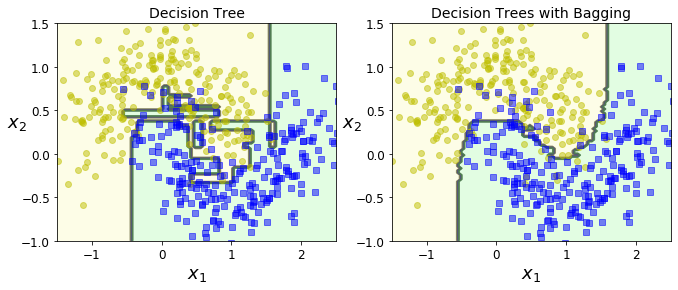

In [16]:
plt.figure(figsize=(11, 4))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.savefig("decision_tree_without_and_with_bagging_plot")
plt.show()

In [17]:
# As you can see above, Bagging generally results in better models, but if you have spare time and CPU power, you can use cross-validation to evaluate both bagging and pasting and select the one that works best.
# With bagging some instances may be sampled several times for any given predictor, while others may not be sampled at all.
    # About 63% of the training set is sampled for a single classifier.
    # The remaining 37% is unsampled and called Out-of-bag instances. They are not the same 37% for all predictors.
    
# Since a predictor never sees these out of bag instances during training, we can use the oob instances as a test set for the model without the need for a separate validation set or cross-validation.
# In Scikit-Learn you can set the oob_score=True when creating a BaggingClassifier to request oob evaluation after training.

# The following code demonstrates this:

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True, random_state=40)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.9013333333333333

In [18]:
# So according to this oob evaluation, this bagging classifier is likely to achieve about 90.1% accuracy on the test set.
# Let's evaluate this:

from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)


0.912

# Random Patches and Random Subspaces

In [19]:
# The BaggingClassifier class supports sampling the features as well. This is controlled by two hyperparameters: max_features and bootstrap_features.
# Each predictor will be trained on a random subset of the input features.
# This is particularly useful when you are dealing with high-dimensional inputs such as images.

# Sampling both training features and instances is called the Random Patches method

# The point of sampling features is that it results in even more predictor diversity, trading a bit more bias for a lower variance.

# Random Forests

In [20]:
# Instead of building a BaggingClassifier and feeding it a DecisionTreeClassifier, you can just use the RandomForestClassifier class which is more convenient and optimized for Decision Trees.
# The following code is equivalent to the RandomForest Classifier from Scikit-Learn:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=16, random_state=42),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1, random_state=42)

In [21]:
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [22]:
# The following code trains a Random Forest classifier with 500 trees (each limited to maximum of 16 nodes), using all available CPU sources:

from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [23]:
np.sum(y_pred == y_pred_rf) / len(y_pred) #almost identical predictions

0.976

In [24]:
# Another great quality of Random Forests is that that make it easy to measure the relative importance of each feature.
# Scikit-Learn does this by looking at how much the tree nodes that use the feature reduce impurity on average across all trees in the forest.
# Scikit-Learn computes this score automatically for each feature after training, and scales the results so that the sum of all importances is equal to 1. You can access the result using the feature_importances_ variable.

# For example, the following code trains a RandomForestClassifier on the Iris Dataset and outputs each features importance.
# It will show that the most important features seem to be the petal length(42%) and width(42%) while sepal length and width aren't that crucial.

from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)



sepal length (cm) 0.11369993712070751
sepal width (cm) 0.02427655674840012
petal length (cm) 0.442472844942238
petal width (cm) 0.4195506611886544


In [25]:
# The code outputs an array of the feature importance scores for the iris dataset:

rnd_clf.feature_importances_

# [sepal length, sepal width, petal length, petal width]

array([0.11369994, 0.02427656, 0.44247284, 0.41955066])

In [26]:
# Similarly if we train a Random Forest classifier on the MNIST dataset and plot each pixel's importance, we can get the following image:

try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1)
    mnist.target = mnist.target.astype(np.int64)
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')

In [27]:
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [28]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot,
              interpolation="nearest")
    plt.axis("off")

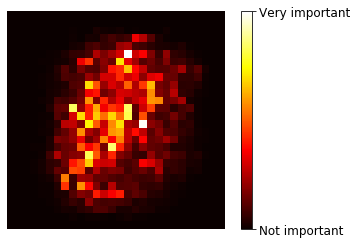

In [29]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

plt.savefig("mnist_feature_importance_plot")
plt.show()

# Adaboost

In [30]:
# Boosting refers to any ensemble method that can combine several weak learners into a strong learner.
# The general idea of most boosting methods is to train predictors sequentially, each trying to correct its predecessor.

# The most popular way is called Adaboost (Adaptive Boosting)
# One way for a new predictor to correct its predecessor is to pay attention to the training instances tat the predecessor underfitted. This results in new predictors focusing more and more on the hard cases.
# The underfitted datasets are then weighted more and new models are trained to factor in the increased weight instances. 
# Once all the predictors are trained, the ensemble makes predictions very much like bagging or pasting, except that predictors have different weights dpending on their overall accuracy on the weighted training set.

In [31]:
# The following code trains an Adaboost classifier based on 200 Decision stumps.
# We use a multiclass version of Adaboost called SAMME.
# Scikit-Learn can use a version of SAMME called SAMME.R which relies on class probabilities rather then predictions and usually performs better

from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
                                                         random_state=None,
                             

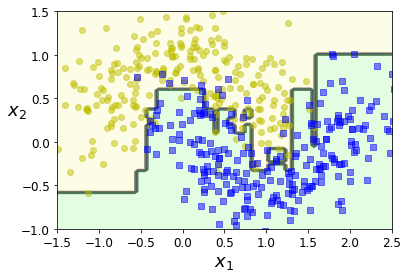

In [32]:
plot_decision_boundary(ada_clf, X, y)

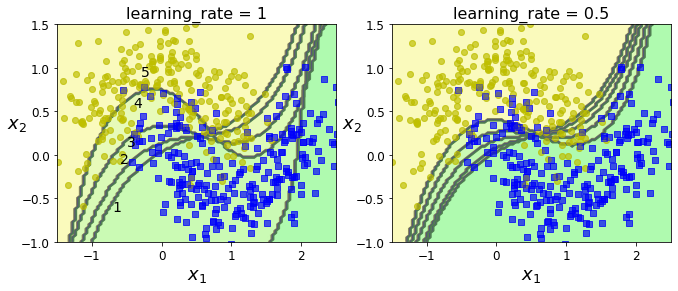

In [36]:
# The following code displays the sequential nature of how Adaboost adjusts the weight of its sequentially created classifiers:

m = len(X_train)

plt.figure(figsize=(11, 4))
for subplot, learning_rate in ((121, 1), (122, 0.5)):
    sample_weights = np.ones(m)
    plt.subplot(subplot)
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.05, gamma="auto", random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights)
        y_pred = svm_clf.predict(X_train)
        sample_weights[y_pred !=y_train] *=(1 + learning_rate)
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot ==121:
        plt.text(-0.7, -0.65, "1", fontsize=14)
        plt.text(-0.6, -0.10, "2", fontsize=14)
        plt.text(-0.5,  0.10, "3", fontsize=14)
        plt.text(-0.4,  0.55, "4", fontsize=14)
        plt.text(-0.3,  0.90, "5", fontsize=14)
        
plt.savefig("boosting plot")
plt.show()

In [37]:
# I think this might be a listing of features that can be tuned for the Adaboost Classifier:

list(m for m in dir(ada_clf) if not m.startswith("_") and m.endswith("_"))

['base_estimator_',
 'classes_',
 'estimator_errors_',
 'estimator_weights_',
 'estimators_',
 'feature_importances_',
 'n_classes_']

# Gradient Boosting

In [38]:
# Gradient Boosting works like Adaboost in that it sequentially adds predictors to an ensemble, each correcting its predecessor.
# However, instead of Tweaking the instance weights at every iteration like Adaboost does, this method tries to fit the new predictor to the residual errors made by the previous predictor.
# Let's train an example of a Gradient Boosting Ensemble:

# Create Test Data:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

# Next let's fit a DecisionTreeRegressor to that generated Test Data:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth= 2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')

In [39]:
# Now let's train the second DecisionTreeRegressor on the residual errors made by the first predictor:

y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')

In [40]:
# Then we train the third DecisionTreeRegressor on the residual errors of the third predictor:

y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')

In [42]:
# Now we have an ensemble of 3 Decision Trees. It can make predictions on a new instance simply by adding up the predictions of all the trees:

X_new = np.array([[0.8]])
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [43]:
y_pred

array([0.75026781])

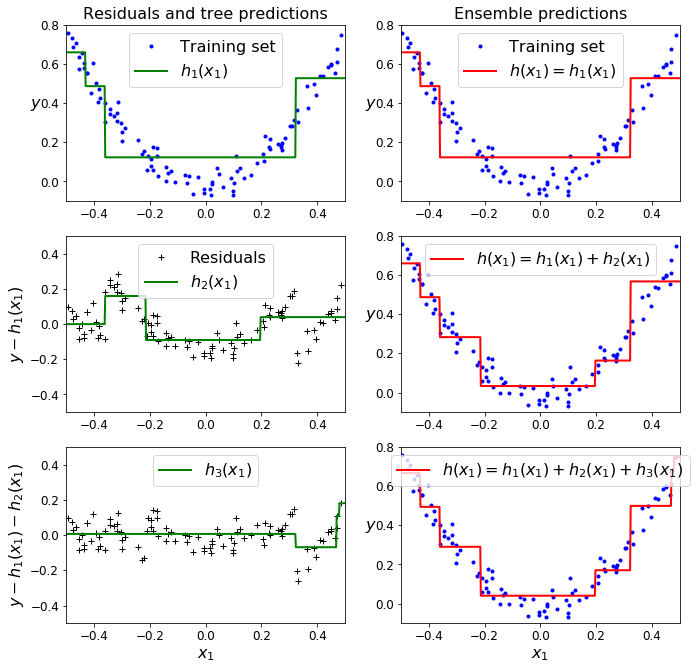

In [44]:
# The following code outputs the representation of predictions of these three trees in the left column and the ensemble's predictions in the right column.
# In the first row, the ensemble has just one tree, so its predictions are exactly the same as the first tree's predictions.
# In the second row, a new tree is trained on the residual errors of the first tree.
# On the right you can see the ensemble's predictions increase in accuracy as you increase the amount of trees:

def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.savefig("gradient_boosting_plot")
plt.show()


In [45]:
# A much simpler way to train Gradient Boosting Regressor Trees  is to use Scikit-Learn's GradientBoostingRegressor Class. It has hyperparameters to control the growth of decision trees and other things:

from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)



GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=1.0, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=3,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [46]:
# The learning_rate hyperparameter scales the contribution of each tree. If you give it a low learning rate of 0.1, you will need more trees to fit the training set, but the predictions will generalize better. This is a regularization technique called shrinkage.
# The following code shows how the learning rate effects fiting of the data:

gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=200,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

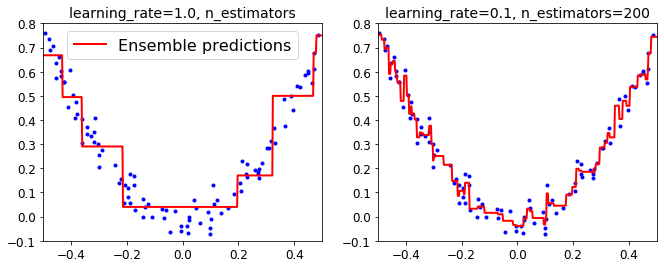

In [48]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)

plt.savefig("gbrt_learning_rate_plot")
plt.show()

In [49]:
# In order to find the optimal number of trees , you can use early stopping to prevent overfitting.

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred) for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=56,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [50]:
min_error = np.min(errors)

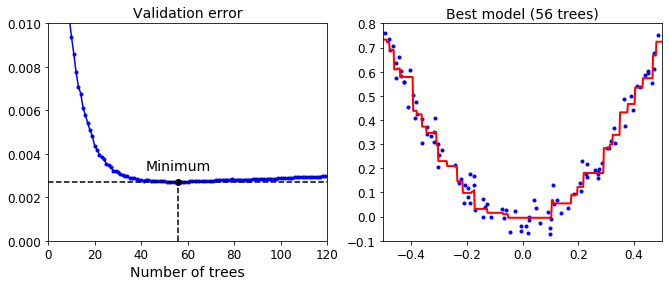

In [52]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)

plt.savefig("early_stopping_gbrt_plot")
plt.show()

# Early Stopping

In [53]:
# It is possible to implement early stopping by actually stopping training early (instead of trainnig a large number of trees first and then looking back to find the optimal number)
# You can do so by setting warm_state=True, which makes Scikit-Learn keep existing trees when the fit() method is called, allowing incremental training.

# The following code stops training when the validation error does not improve for five iterations in a row:

gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break # early stopping

In [54]:
print(gbrt.n_estimators)

61


In [55]:
print("Minimum validation MSE:", min_val_error)

Minimum validation MSE: 0.002712853325235463
